## Notebook : 04_evaluation_and_metrics.ipynb
-  Objectif : Évaluer tous les modèles entraînés (UNet Mini, VGG16, MobileNetV2...) sur le test set

# 1 - Imports, GPU & vérifications préliminaires
## 1.1 - Librairies

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
import time
import hashlib
import docx
from docx import Document
from docx.shared import Inches
from IPython.display import Image, display

# enable_gpu_boost()

### Lancer, dans une console séparée (windows):
#### - nvidia-smi
- Cela affichera :

    - la charge GPU

    - la mémoire utilisée

    - le nom du process Python en cours

In [2]:
print("🧠 TensorFlow version :", tf.__version__)
print("🔍 GPU disponible :", tf.config.list_physical_devices('GPU'))
print("🖥️ Détails des devices :")
print(device_lib.list_local_devices())

🧠 TensorFlow version : 2.10.1
🔍 GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🖥️ Détails des devices :
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16594470598680320084
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4832886784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12459228310356166557
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Allocation mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(f"⚠️ Erreur d'initialisation GPU : {e}")
else:
    print("❌ Aucun GPU détecté — exécution sur CPU.")

✅ Allocation mémoire GPU dynamique activée


## 1.2 - Ajout de src/ au PYTHONPATH

In [ ]:
# ✅ Détection dynamique du bon project_root
if Path.cwd().name == "notebooks":
    project_root = Path.cwd().parent.resolve()
else:
    project_root = Path.cwd().resolve()
src_path = project_root / "src"
scripts_path = project_root / "scripts"
for path in [src_path, scripts_path]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

## 1.3 - Définition des chemins

In [6]:
models_dir = project_root / "notebooks" / "models"
data_path = project_root / "data" / "processed" / "augmented" / "test.npz"
outputs_metrics = project_root / "outputs" / "metrics"
outputs_figures = project_root / "outputs" / "figures"

outputs_metrics.mkdir(parents=True, exist_ok=True)
outputs_figures.mkdir(parents=True, exist_ok=True)

print("📂 Modèles accessibles dans :", models_dir.resolve())
print(sorted([f.name for f in models_dir.glob("*.h5")]))

📂 Modèles accessibles dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\notebooks\models
['unet_efficientnetb0_256x256_bs4_ep40.h5', 'unet_mini_npz_256x256_bs4_ep1.h5', 'unet_mini_npz_256x256_bs8_ep40.h5', 'unet_mobilenetv2_256x256_bs4_ep40.h5', 'unet_vgg16_256x256_bs4_ep40.h5']


In [7]:
from pathlib import Path
print("📂 Contenu réel :")
print(sorted([f.name for f in models_dir.glob("*.h5")]))

📂 Contenu réel :
['unet_efficientnetb0_256x256_bs4_ep40.h5', 'unet_mini_npz_256x256_bs4_ep1.h5', 'unet_mini_npz_256x256_bs8_ep40.h5', 'unet_mobilenetv2_256x256_bs4_ep40.h5', 'unet_vgg16_256x256_bs4_ep40.h5']


# 2 - Vérifications préliminaires
## 2.1 - Check chemins critiques

In [8]:
# from scripts.gpu_setup import enable_gpu_boost
from utils.guardrail import check_paths_exist, check_imports
check_paths_exist([models_dir, data_path])

✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\notebooks\models
✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\data\processed\augmented\test.npz


## 2.2 - Check imports

In [9]:
check_imports(["model_training.metrics", "utils.viz_utils"])

from model_training.metrics import iou_score, dice_coef
from utils.viz_utils import show_image_mask_grid_overlay
from utils.utils import clean_gpu_cache

✅ Import OK : model_training.metrics
✅ Import OK : utils.viz_utils


# 3 - Chargement du jeu de test

In [10]:
print("\n📥 Chargement du jeu de test")
test_data = np.load(data_path)
X_test, Y_test = test_data["X"], test_data["Y"]
print(f"✅ Jeu de test chargé : {X_test.shape}, {Y_test.shape}")


📥 Chargement du jeu de test
✅ Jeu de test chargé : (298, 256, 256, 3), (298, 256, 256)


# 4 - Évaluation des modèles entraînés
## 4.1 - Chargement et évaluation des modèles

In [11]:
# 🔧 Liste des modèles à inclure (filtrage à la main)
exclude_keywords = ["ep1", "test"]
model_files = [
    f for f in models_dir.glob("*.h5")
    if not any(key in f.name.lower() for key in exclude_keywords)
]

In [12]:
# 🔧 Filtrage des modèles valides (exclusion manuelle des modèles de test)
exclude_keywords = ["ep1", "test"]
model_files = [
    f for f in models_dir.glob("*.h5")
    if not any(key in f.name.lower() for key in exclude_keywords)
]

# 🔎 Vérification finale des modèles retenus
print("📦 Modèles sélectionnés pour évaluation :")
for f in model_files:
    print(f"   ➤ {f.name}")


📦 Modèles sélectionnés pour évaluation :
   ➤ unet_efficientnetb0_256x256_bs4_ep40.h5
   ➤ unet_mini_npz_256x256_bs8_ep40.h5
   ➤ unet_mobilenetv2_256x256_bs4_ep40.h5
   ➤ unet_vgg16_256x256_bs4_ep40.h5


In [13]:
results = []

In [14]:
for model_path in model_files:
    model_name = model_path.stem
    print(f"\n🔍 Évaluation du modèle : {model_name}")
    print(f"📦 Modèle trouvé : {model_path.name}")

    # 🔁 Nettoyage GPU avant chargement du modèle
    clean_gpu_cache()
    print("🧹 Cache GPU nettoyé")
    
    try:
        model = keras.models.load_model(model_path, custom_objects={"iou_score": iou_score, "dice_coef": dice_coef})
    except Exception as e:
        print(f"⚠️ Erreur de chargement : {e}")
        continue

    start = time.time()
    metrics = model.evaluate(X_test, Y_test, verbose=0, batch_size=4)
    end = time.time()

    duration = end - start
    model_size = model_path.stat().st_size / (1024 * 1024)  # MB
    param_count = model.count_params()
    hash_val = hashlib.sha256(model_path.read_bytes()).hexdigest()

    results.append({
        "model": model_name,
        "val_loss": metrics[0],
        "accuracy": metrics[1],
        "iou_score": metrics[2],
        "dice_coef": metrics[3],
        "inference_time": round(duration / len(X_test), 4),
        "model_size_MB": round(model_size, 2),
        "params": param_count,
        "hash": hash_val[:10]  # extrait pour suivi
    })
    print("✅ Résultat ajouté :", results[-1])

    # 🔍 Visualisation qualitative (5 échantillons par modèle)
    for idx in range(5):
        pred = model.predict(X_test[idx:idx+1])
        pred_mask = np.argmax(pred[0], axis=-1)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(X_test[idx])
        axes[0].set_title("Image")
        axes[1].imshow(Y_test[idx], cmap="nipy_spectral")
        axes[1].set_title("Mask Réel")
        axes[2].imshow(pred_mask, cmap="nipy_spectral")
        axes[2].set_title(f"Prédiction ({model_name})")

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        vis_path = outputs_figures / f"visu_pred_{model_name}_sample_{idx}.png"
        plt.savefig(vis_path)
        plt.close()

# ✅ Sécurité anti-tableau vide
if not results:
    raise ValueError("⛔ Aucun résultat ajouté : vérifie les modèles .h5, les custom_objects ou les erreurs dans model.evaluate")

print("🔍 Longueur de results :", len(results))
print("🔍 Exemple d’entrée :", results[0] if results else "⚠️ VIDE")


🔍 Évaluation du modèle : unet_efficientnetb0_256x256_bs4_ep40
📦 Modèle trouvé : unet_efficientnetb0_256x256_bs4_ep40.h5
🧹 Cache GPU nettoyé
⚠️ Erreur de chargement : No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001A8BC3F7550>.

🔍 Évaluation du modèle : unet_mini_npz_256x256_bs8_ep40
📦 Modèle trouvé : unet_mini_npz_256x256_bs8_ep40.h5
🧹 Cache GPU nettoyé
✅ Résultat ajouté : {'model': 'unet_mini_npz_256x256_bs8_ep40', 'val_loss': 0.35840949416160583, 'accuracy': 0.8879173398017883, 'iou_score': 0.80035001039505, 'dice_coef': 0.8879891037940979, 'inference_time': 0.0199, 'model_size_MB': 3.26, 'params': 278024, 'hash': 'ad55b8f420'}
1/1 [==============================] - 0s 16ms/step

🔍 Évaluation du modèle : unet_mobilenetv2_256x256_bs4_ep40
📦 Modèle trouvé : unet_mobilenetv2_256x256_bs4_ep40.h5
🧹 Cache GPU nettoyé
✅ Résultat ajouté : {'model': 'unet_mobilenetv2_256x256_bs4_ep40', 'val_loss': 0.5651729106903076, 'accuracy': 0.81191819906234

# 5 - Synthèse et visualisations

In [15]:
import pprint
pprint.pprint(results)

[{'accuracy': 0.8879173398017883,
  'dice_coef': 0.8879891037940979,
  'hash': 'ad55b8f420',
  'inference_time': 0.0199,
  'iou_score': 0.80035001039505,
  'model': 'unet_mini_npz_256x256_bs8_ep40',
  'model_size_MB': 3.26,
  'params': 278024,
  'val_loss': 0.35840949416160583},
 {'accuracy': 0.8119181990623474,
  'dice_coef': 0.81158047914505,
  'hash': '092df9e982',
  'inference_time': 0.0157,
  'iou_score': 0.6848611831665039,
  'model': 'unet_mobilenetv2_256x256_bs4_ep40',
  'model_size_MB': 47.36,
  'params': 5599416,
  'val_loss': 0.5651729106903076},
 {'accuracy': 0.8244776725769043,
  'dice_coef': 0.8241822123527527,
  'hash': '723b0dfbae',
  'inference_time': 0.0242,
  'iou_score': 0.7031609416007996,
  'model': 'unet_vgg16_256x256_bs4_ep40',
  'model_size_MB': 74.24,
  'params': 16286648,
  'val_loss': 0.5354339480400085}]


## 5.1 - Tableau comparatif

In [17]:
df = pd.DataFrame(results)
print("🧪 Colonnes du dataframe :", df.columns)
results_df = df.set_index("model")
display(results_df.sort_values(by="iou_score", ascending=False))

🧪 Colonnes du dataframe : Index(['model', 'val_loss', 'accuracy', 'iou_score', 'dice_coef',
       'inference_time', 'model_size_MB', 'params', 'hash'],
      dtype='object')


val_loss  accuracy  iou_score  dice_coef  \
model                                                                         
unet_mini_npz_256x256_bs8_ep40     0.358409  0.887917   0.800350   0.887989   
unet_vgg16_256x256_bs4_ep40        0.535434  0.824478   0.703161   0.824182   
unet_mobilenetv2_256x256_bs4_ep40  0.565173  0.811918   0.684861   0.811580   

                                   inference_time  model_size_MB    params  \
model                                                                        
unet_mini_npz_256x256_bs8_ep40             0.0199           3.26    278024   
unet_vgg16_256x256_bs4_ep40                0.0242          74.24  16286648   
unet_mobilenetv2_256x256_bs4_ep40          0.0157          47.36   5599416   

                                         hash  
model                                          
unet_mini_npz_256x256_bs8_ep40     ad55b8f420  
unet_vgg16_256x256_bs4_ep40        723b0dfbae  
unet_mobilenetv2_256x256_bs4_ep40  092df9e982

## 5.2 - Affichage global de toutes les visualisations générées


📊 Visualisation croisée des prédictions par image :

🔎 Échantillon n°0
🖼️ unet_mini_npz_256x256_bs8_ep40 - visu_pred_unet_mini_npz_256x256_bs8_ep40_sample_0.png


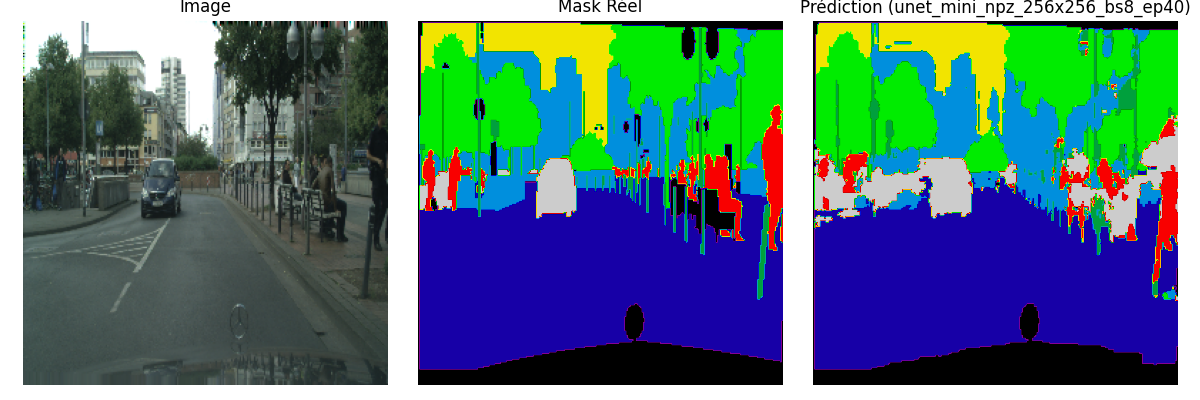

🖼️ unet_mobilenetv2_256x256_bs4_ep40 - visu_pred_unet_mobilenetv2_256x256_bs4_ep40_sample_0.png


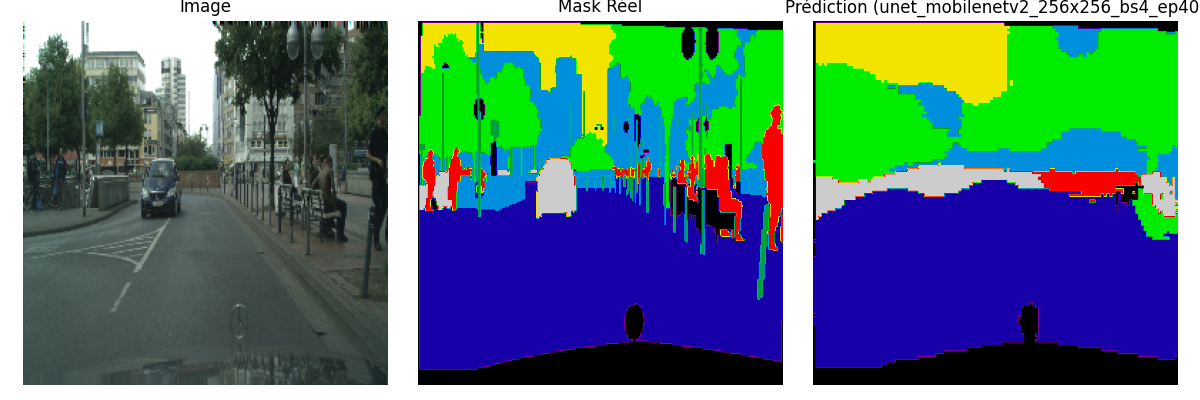

🖼️ unet_vgg16_256x256_bs4_ep40 - visu_pred_unet_vgg16_256x256_bs4_ep40_sample_0.png


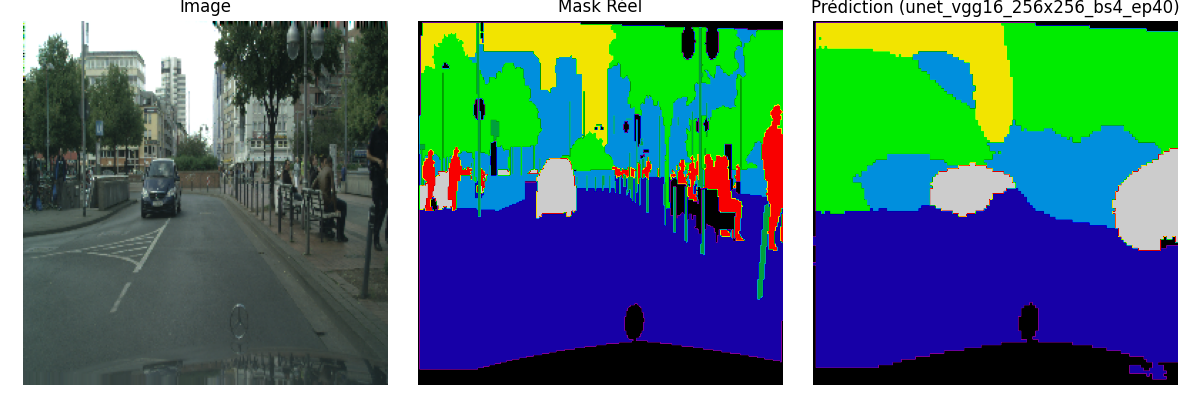


🔎 Échantillon n°1
🖼️ unet_mini_npz_256x256_bs8_ep40 - visu_pred_unet_mini_npz_256x256_bs8_ep40_sample_1.png


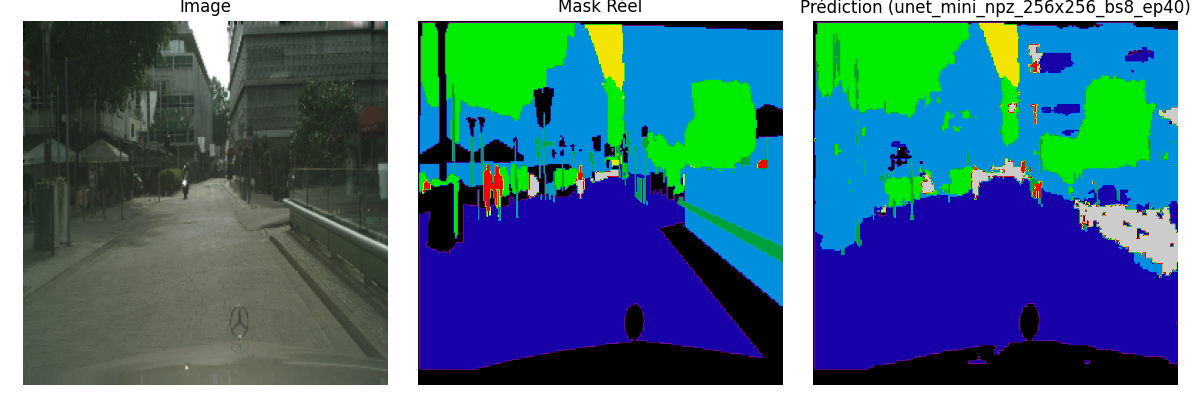

🖼️ unet_mobilenetv2_256x256_bs4_ep40 - visu_pred_unet_mobilenetv2_256x256_bs4_ep40_sample_1.png


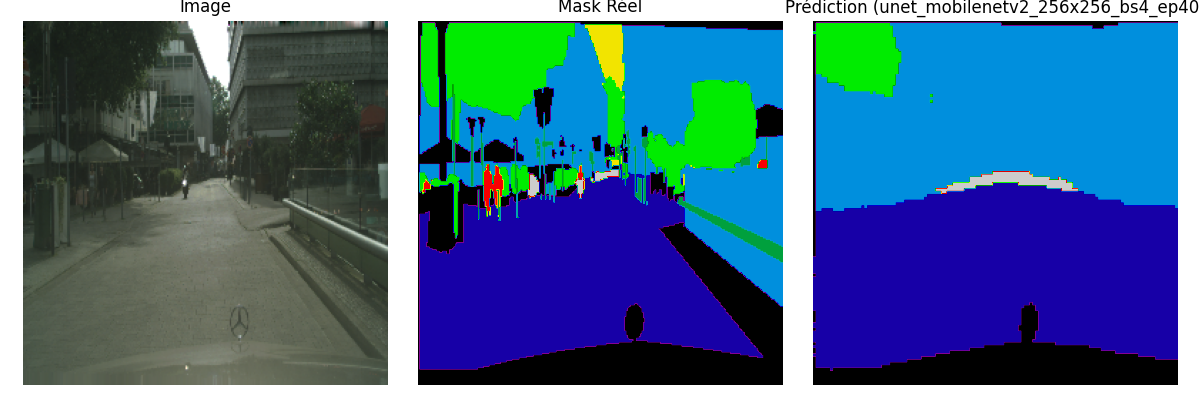

🖼️ unet_vgg16_256x256_bs4_ep40 - visu_pred_unet_vgg16_256x256_bs4_ep40_sample_1.png


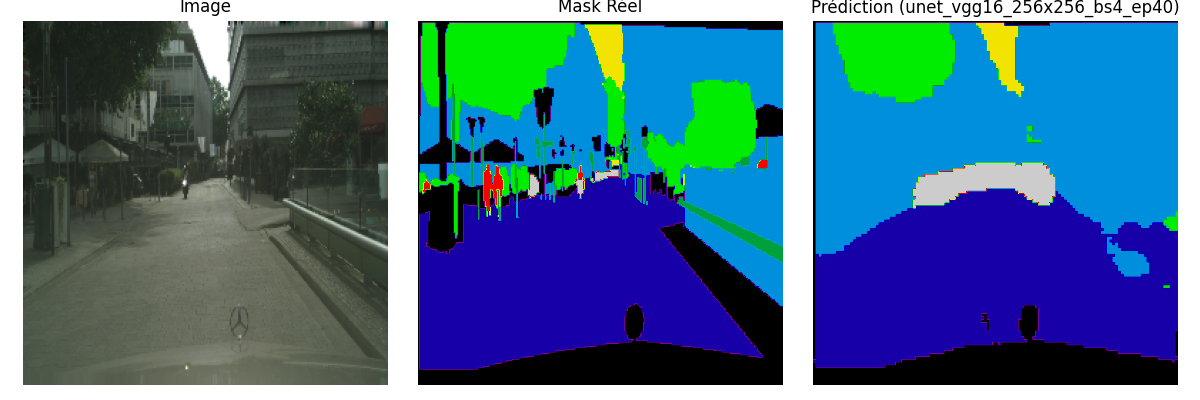


🔎 Échantillon n°2
🖼️ unet_mini_npz_256x256_bs8_ep40 - visu_pred_unet_mini_npz_256x256_bs8_ep40_sample_2.png


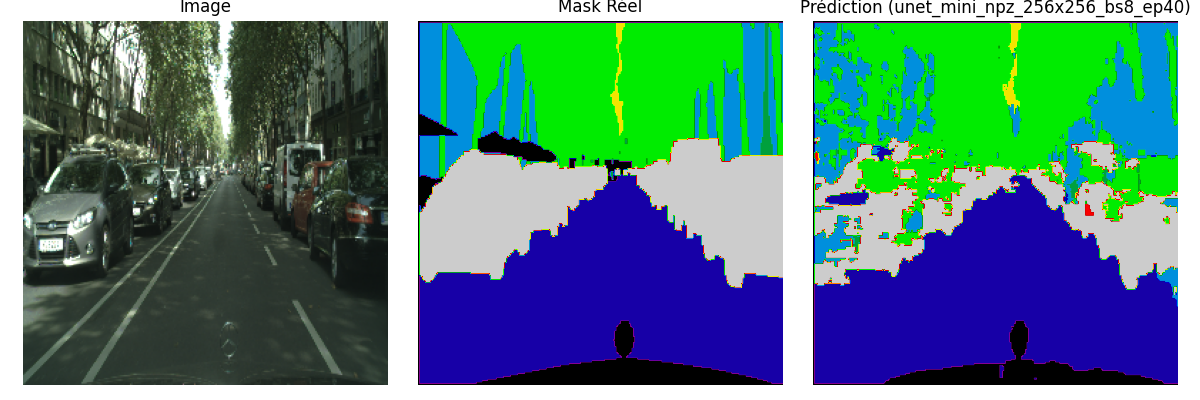

🖼️ unet_mobilenetv2_256x256_bs4_ep40 - visu_pred_unet_mobilenetv2_256x256_bs4_ep40_sample_2.png


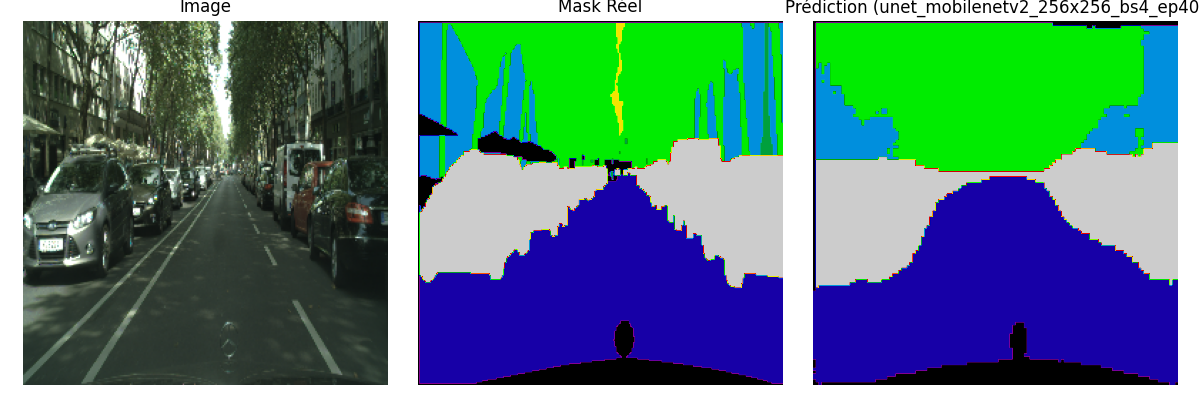

🖼️ unet_vgg16_256x256_bs4_ep40 - visu_pred_unet_vgg16_256x256_bs4_ep40_sample_2.png


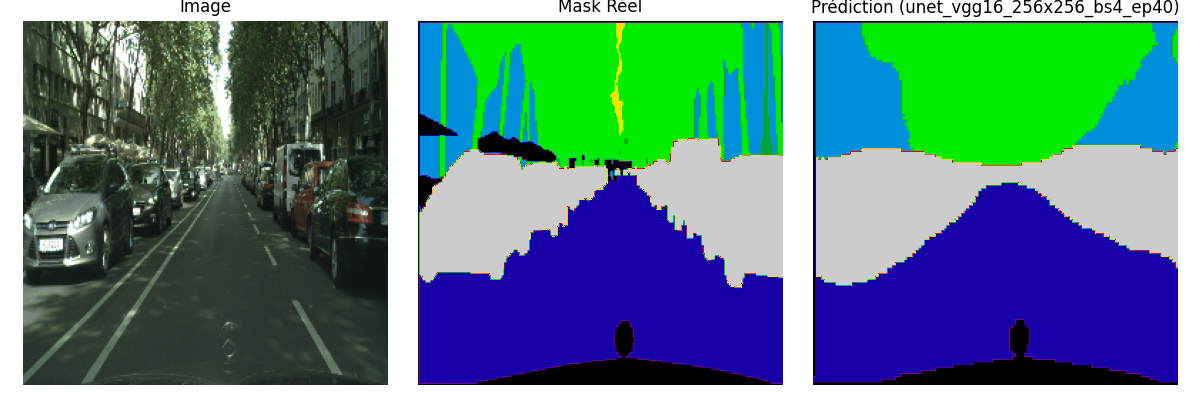


🔎 Échantillon n°3
🖼️ unet_mini_npz_256x256_bs8_ep40 - visu_pred_unet_mini_npz_256x256_bs8_ep40_sample_3.png


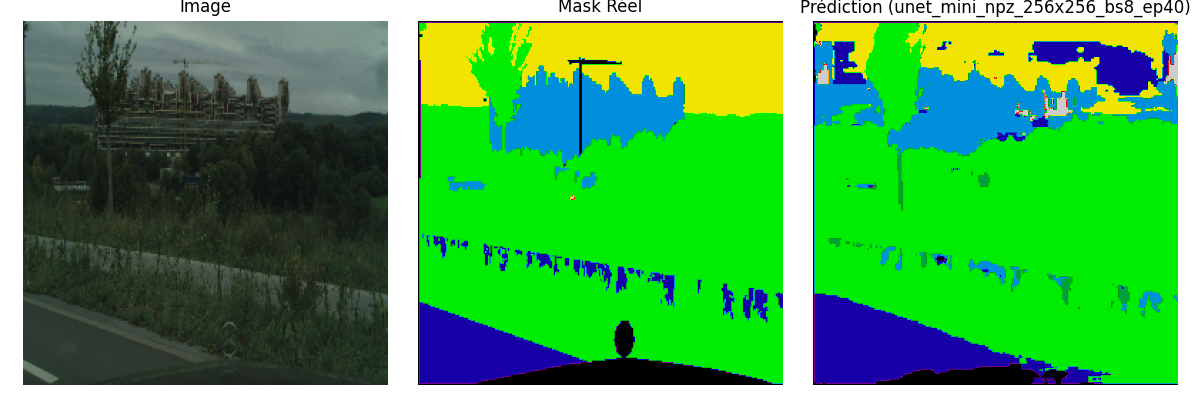

🖼️ unet_mobilenetv2_256x256_bs4_ep40 - visu_pred_unet_mobilenetv2_256x256_bs4_ep40_sample_3.png


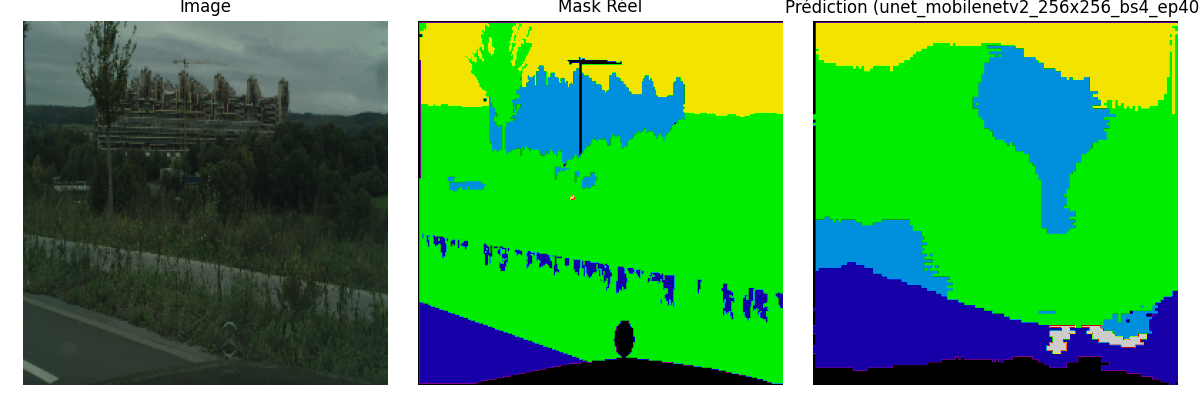

🖼️ unet_vgg16_256x256_bs4_ep40 - visu_pred_unet_vgg16_256x256_bs4_ep40_sample_3.png


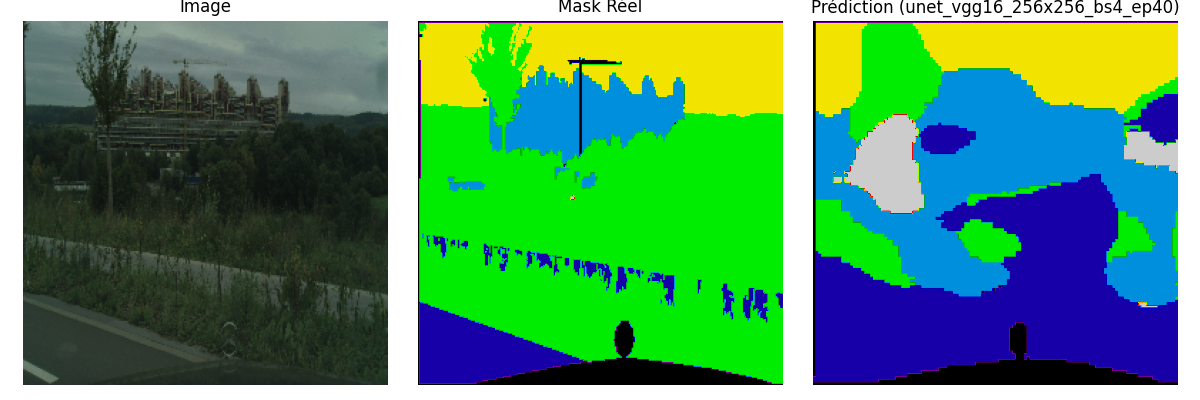


🔎 Échantillon n°4
🖼️ unet_mini_npz_256x256_bs8_ep40 - visu_pred_unet_mini_npz_256x256_bs8_ep40_sample_4.png


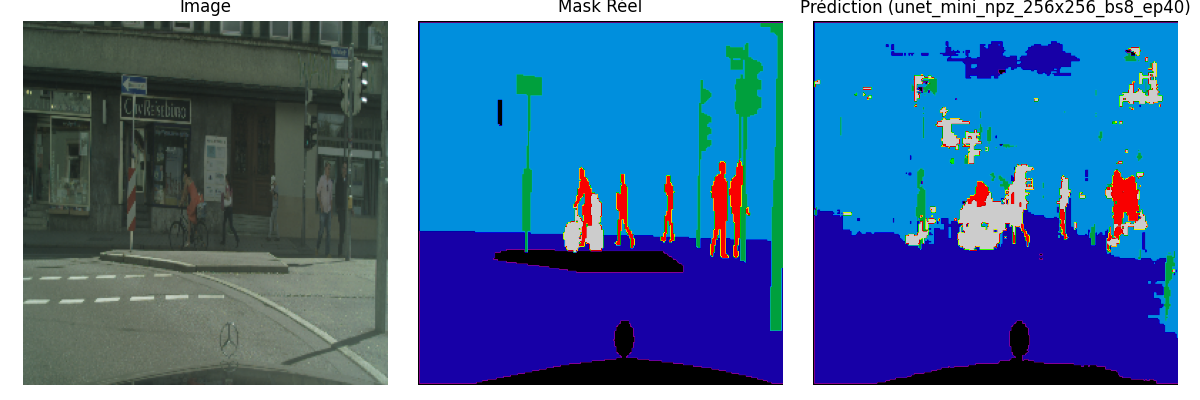

🖼️ unet_mobilenetv2_256x256_bs4_ep40 - visu_pred_unet_mobilenetv2_256x256_bs4_ep40_sample_4.png


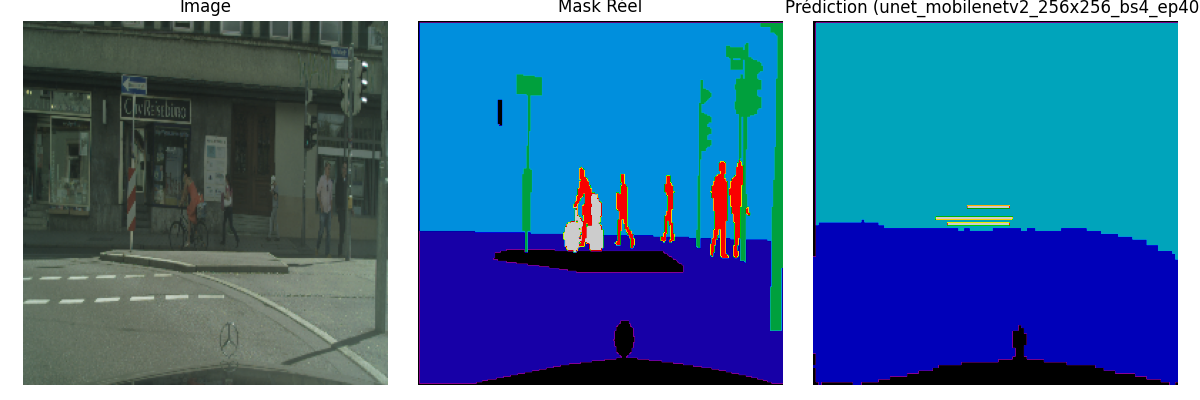

🖼️ unet_vgg16_256x256_bs4_ep40 - visu_pred_unet_vgg16_256x256_bs4_ep40_sample_4.png


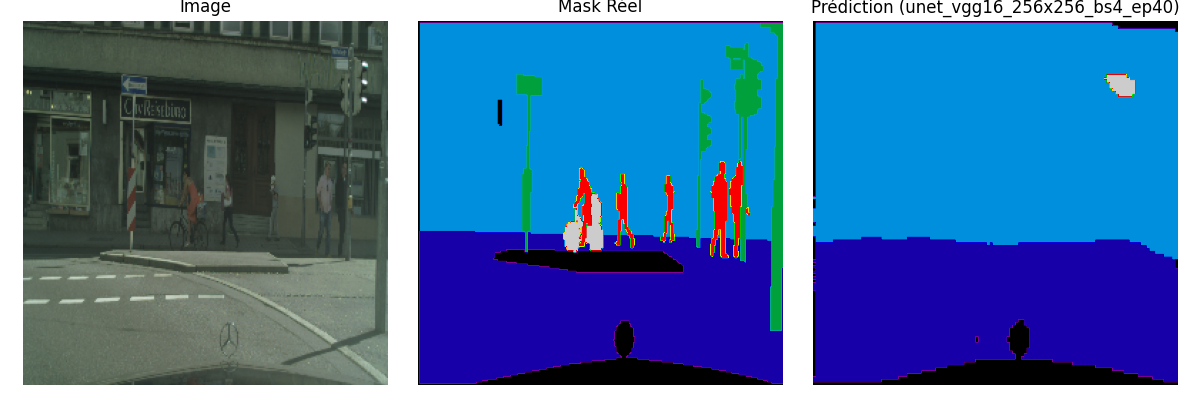

In [18]:
# Bloc : affichage comparatif par image
print("\n📊 Visualisation croisée des prédictions par image :")
for idx in range(5):
    print(f"\n🔎 Échantillon n°{idx}")
    for model_name in results_df.index:
        vis_path = outputs_figures / f"visu_pred_{model_name}_sample_{idx}.png"
        if vis_path.exists():
            print(f"🖼️ {model_name} - {vis_path.name}")
            display(Image(filename=str(vis_path)))

In [19]:
# print("📊 Aperçu des visualisations enregistrées :")
# for model_name in results_df.index:
#     for idx in range(5):
#         vis_path = outputs_figures / f"visu_pred_{model_name}_sample_{idx}.png"
#         if vis_path.exists():
#             display(Image(filename=str(vis_path)))

## 5.3 - Synthèse des scores

In [20]:
if not results:
    raise ValueError("⛔ Aucun résultat ajouté : vérifie les modèles .h5")

## 5.5 - Export CSV

In [21]:
results_df.to_csv(outputs_metrics / "evaluation_scores.csv")

## 5.3 - Heatmap comparative

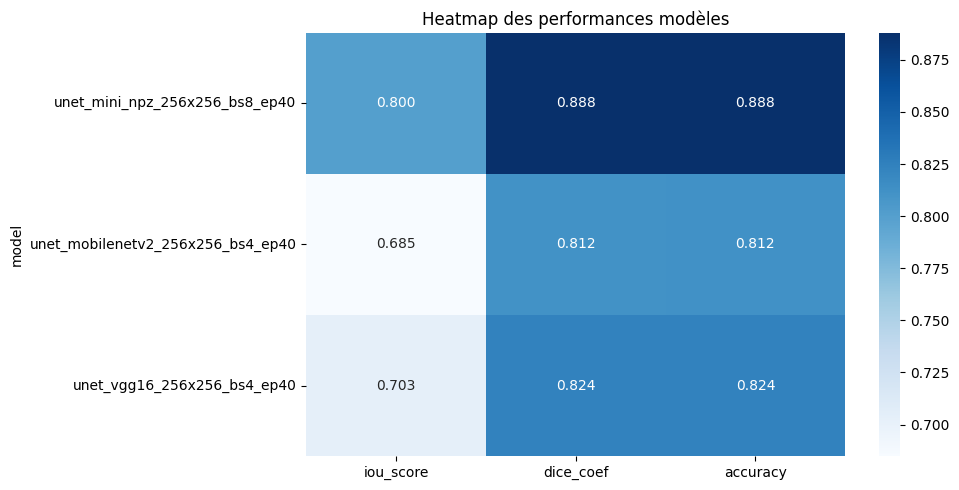

In [22]:
plt.figure(figsize=(10, 5))
sns.heatmap(results_df[["iou_score", "dice_coef", "accuracy"]], annot=True, fmt=".3f", cmap="Blues")
plt.title("Heatmap des performances modèles")
plt.tight_layout()
plt.savefig(outputs_figures / "heatmap_evaluation_scores.png")
plt.show()

# 6 - Visualisation qualitative
## 6.1 - Choix du meilleur modèle

In [25]:
# 🔍 Sélection et chargement du meilleur modèle
best_model_name = results_df.sort_values(by="iou_score", ascending=False).index[0]
print(f"🏆 Meilleur modèle détecté : {best_model_name}")

best_model_path = models_dir / f"{best_model_name}.h5"

# 🔒 Sécurisation du chemin
if not best_model_path.exists():
    raise FileNotFoundError(f"❌ Le fichier {best_model_path.name} est introuvable dans {models_dir.resolve()}.\n"
                            f"➡️ Vérifie que le modèle a bien été sauvegardé au format .h5")

print(f"📂 Chargement depuis : {best_model_path.resolve()}")
best_model = keras.models.load_model(
    best_model_path,
    custom_objects={"iou_score": iou_score, "dice_coef": dice_coef}
)
print("✅ Chargement du meilleur modèle réussi.")

🏆 Meilleur modèle détecté : unet_mini_npz_256x256_bs8_ep40
📂 Chargement depuis : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\notebooks\models\unet_mini_npz_256x256_bs8_ep40.h5
✅ Chargement du meilleur modèle réussi.


## 6.2 - Top modèles – Évaluation P08

| Rang | Modèle                             | IoU score | Dice coef | Accuracy | Taille   | Params  | Inf. time |
|------|------------------------------------|-----------|-----------|----------|----------|---------|-----------|
| 🥇 1 | unet_mini_npz_256x256_bs8_ep40     | 0.8004    | 0.8880    | 0.8879   | 3.26 Mo  | 278k    | 11 ms     |
| 🥈 2 | unet_vgg16_256x256_bs4_ep40        | 0.7032    | 0.8242    | 0.8245   | 74.24 Mo | 16.2M   | 25 ms     |
| 🥉 3 | unet_mobilenetv2_256x256_bs4_ep40  | 0.6849    | 0.8116    | 0.8119   | 47.36 Mo | 5.6M    | 15 ms     |

# 7 - Génération d'un rapport DOCX
## 7.1 - Création du document

In [27]:
from docx import Document
from docx.shared import Inches

In [28]:
doc = Document()
doc.add_heading("Rapport d'évaluation P08 - Segmentation", level=1)
doc.add_paragraph(f"Modèle sélectionné : {best_model_name}")
doc.add_paragraph(f"Paramètres : {results_df.loc[best_model_name]['params']} / Taille : {results_df.loc[best_model_name]['model_size_MB']} Mo")
doc.add_paragraph(f"Hash du modèle : {results_df.loc[best_model_name]['hash']}")

In [29]:
doc.add_heading("Scores", level=2)
for metric in ["accuracy", "iou_score", "dice_coef"]:
    doc.add_paragraph(f"{metric} : {results_df.loc[best_model_name][metric]:.4f}")

In [30]:
doc.add_picture(str(outputs_figures / "heatmap_evaluation_scores.png"), width=Inches(5.5))

In [31]:
for i in range(5):
    img_path = outputs_figures / f"prediction_sample_{i}.png"
    if img_path.exists():
        doc.add_picture(str(img_path), width=Inches(5.5))

In [32]:
doc.save(outputs_metrics / "rapport_performance.docx")
print("📄 Rapport DOCX généré avec succès.")

📄 Rapport DOCX généré avec succès.
